# A1 - Analyzing Language Features
This notebook analyzes the most popular languages in filtered and selected repositories.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from src.db.database import connect, Notebook, PythonFile
from src.helpers.h7_analysis_helpers import get_python_version
from src.config.states import QUERY_FILTERED, QUERY_SELECTED
from src.config.states import NB_AGGREGATED, PF_AGGREGATED

## 1 - What are the most popular programming languages in Data Science projects?
After filtering repositories that are likely courses we will analyze the remaning repositories we collected from Github.

In [4]:
with connect() as session:
    queries = pd.read_sql_table("queries", session.connection())
    filtered = queries[(queries["state"] ==  QUERY_FILTERED) |
                       (queries["state"] == QUERY_SELECTED)]
print('Total of Repositories Filtered: ',len(filtered))

Total of Repositories Filtered:  10


### 1.1 - Languages
In this section we will investigate the languages that are use in Data Science Projects

#### Number of Languages per Repository

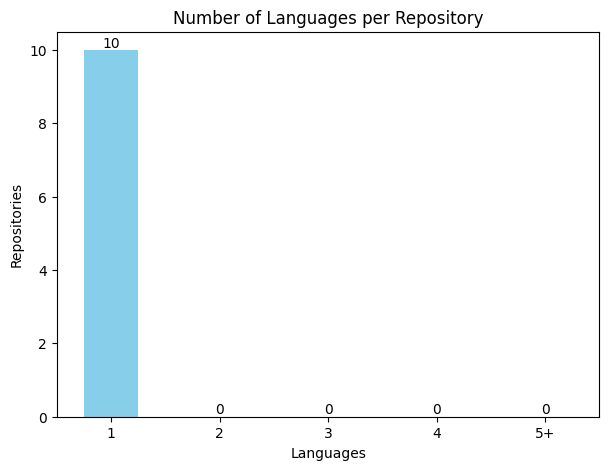

In [3]:
languages = filtered.languages\
    .value_counts(dropna=False, bins = [1,2, 3, 4, 5, 100])\
    .sort_index().to_frame("Repositories")

fig1, ax = plt.subplots( figsize=(7,5))
languages.plot.bar(title='Number of Languages per Repository', color='skyblue', ax=ax,
                   xlabel='Languages', ylabel='Repositories').get_legend().remove()
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['1', '2','3', '4', '5+'], rotation=0)
ax.bar_label(ax.containers[0], label_type='edge');

#### Most Popular Primary Language

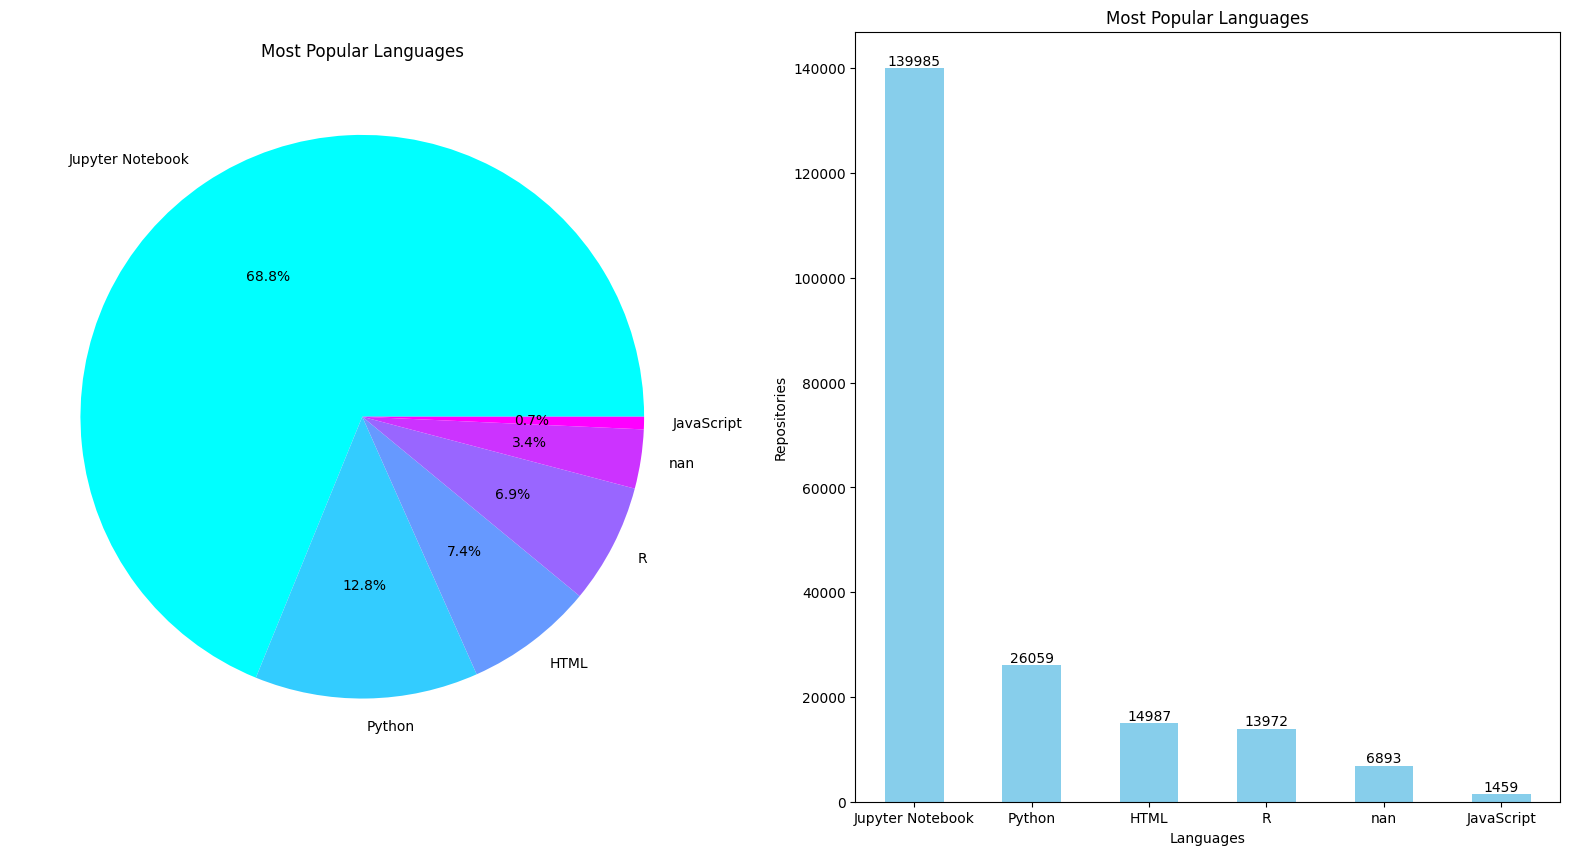

In [18]:
primary_languages = filtered.primary_language\
    .value_counts(dropna=False)\
    .rename_axis('primary_language').to_frame("Repositories")

pl = primary_languages[:5].reset_index(level=0)
others = pd.DataFrame(data = {
    'PrimaryLanguage' : ['Other Languages'],
    'Repositories' : [primary_languages['Repositories'][5:].sum()]
})

pl2 = pd.concat([pl,others]).reset_index(drop=True)\
    .sort_values(by='Repositories', ascending=False)

fig2, ax = plt.subplots(ncols=2, figsize=(20,10))
pl2.plot.pie(ax=ax[0], y="Repositories", title="Most Popular Languages",
             labels=pl2["primary_language"], ylabel='',cmap="cool",
             autopct='%1.1f%%', ).get_legend().remove()
pl2.plot.bar(ax=ax[1], color="skyblue", title="Most Popular Languages",
             xlabel='Languages', ylabel='Repositories',
             ).get_legend().remove()
plt.xticks(ticks=[0, 1, 2, 3, 4,5],
           labels=pl2["primary_language"], rotation=0)
ax[1].bar_label(ax[1].containers[0], label_type='edge');

### 1.2 - Respositories with Jupyter Notebooks and Python as Primary Language
Since Jupyter Notebook and Python are the most popular languages, we selected the repositories that have them as primary language for futher analysis.

In [19]:
selected = queries[(queries["state"] == QUERY_SELECTED)]
print('Total of Repositories Selected: ', len(selected))

Total of Repositories Selected:  10


In [20]:
with connect() as session:
    notebooks = pd.read_sql_table("notebooks", session.connection())
    python_files = pd.read_sql_table("python_files", session.connection())

print('Out of the {} selected repositories we found:'.format(len(selected)))
print('- A total of Notebooks:', len(notebooks))
print('- A total of Python Files:', len(python_files))

Out of the 10 selected repositories we found:
- A total of Notebooks: 48
- A total of Python Files: 2


#### 1.2.1 - Jupyter Notebooks
 Which languages are they in? Which versions?

Out of 48 Notebooks:
- Python Notebooks: 48


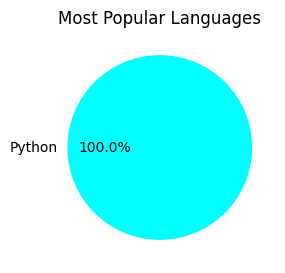

In [32]:
fig3, ax = plt.subplots( figsize=(3,3))
languages = notebooks.language\
    .value_counts(dropna=False)\
    .rename_axis('primary_language')\
    .to_frame("Notebooks").reset_index(drop=False)\
    .sort_values(by='Notebooks', ascending=False)


languages.plot.pie(ax=ax, y="Notebooks", title="Most Popular Languages",
             labels=["Python","R","Unknown"], ylabel='',cmap="cool",
             autopct='%1.1f%%', ).get_legend().remove()


print("Out of {} Notebooks:".format(len(notebooks)))
print('- Python Notebooks:', languages["Notebooks"][0])
if len(languages["Notebooks"]) == 2:
    print('- R Notebooks:', languages["Notebooks"][1])
if len(languages["Notebooks"]) == 3:
    print('- Unkwon language Notebooks:', languages["Notebooks"][2])

Since most notebooks are in Python, henceforth we will only analyze those in Python

In [33]:
python_notebooks = notebooks.query("language == 'python'")

The most common Python Versions and Notebook Formats are:

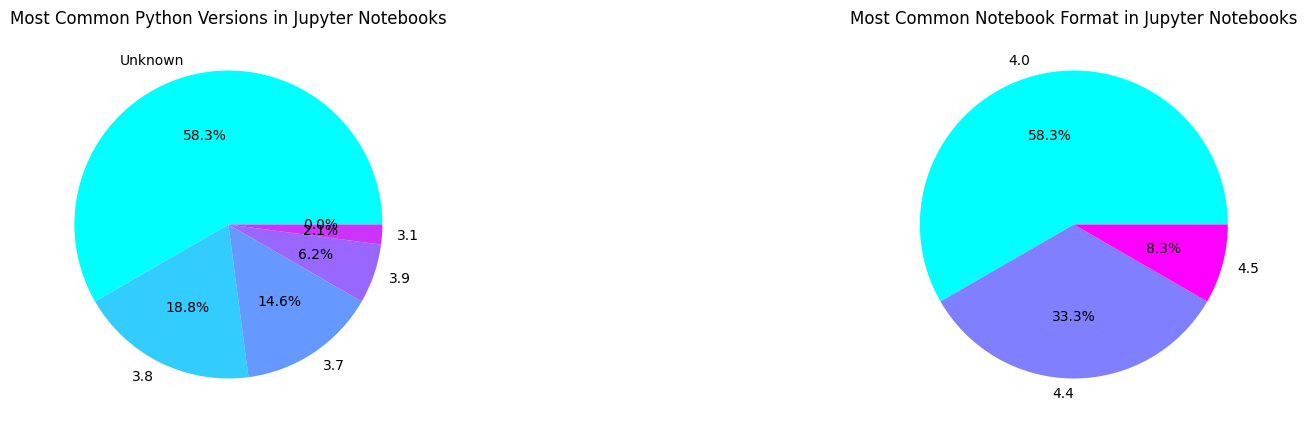

In [42]:
fig4, axes = plt.subplots(ncols=2, figsize=(20,5))
python_version = get_python_version(python_notebooks)
python_version.plot.pie(ax=axes[0], y="Notebooks", title="Most Common Python Versions in Jupyter Notebooks",
             labels=python_version["Versions"], ylabel='',cmap="cool",
             autopct='%1.1f%%', ).get_legend().remove()

nb_format = python_notebooks.nbformat.value_counts(dropna=False)\
        .rename_axis('Formats').to_frame("Notebooks").reset_index(level=0)
nb_format.plot.pie(ax=axes[1], y="Notebooks", title="Most Common Notebook Format in Jupyter Notebooks",
             labels=nb_format["Formats"], ylabel='',cmap="cool",
             autopct='%1.1f%%', ).get_legend().remove()



#### Valid Notebooks
Before extracting data from the notebooks we excluded those that were empty or did not have a kernel or notebook format.
After the extraction, those that did not have any processing errors are considered valid notebooks for the next analysis.

In [40]:
with connect() as session:
    valid_notebooks = session.query(Notebook)\
        .filter(Notebook.state == NB_AGGREGATED).count()

    print('Out of the {} Notebooks:'.format(len(python_notebooks)))
    print('- Valid Python Notebooks: {}'.format(valid_notebooks))
    print('- Invalid Python Notebooks: {}'.format(len(python_notebooks)-valid_notebooks))

Out of the 48 Notebooks:
- Valid Python Notebooks: 46
- Invalid Python Notebooks: 2


#### 1.2.2 - Python Files
We excluded empty python files from extraction. Those that did not have any processing errors are considered valid python files for the next analysis.

In [41]:
with connect() as session:
    valid_python_files = session.query(PythonFile)\
        .filter(PythonFile.state == PF_AGGREGATED).count()

    print('Out of the {} Python Files:'.format(len(python_files)))
    print('- Valid Python Files: {}'.format(valid_python_files))
    print('- Invalid Python Files: {}'.format(len(python_files)-valid_python_files))

Out of the 2 Python Files:
- Valid Python Files: 2
- Invalid Python Files: 0
